In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
!nvidia-smi

Wed Mar 26 13:24:09 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   37C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Install

In [2]:
!pip install -q supervision ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 949.8/949.8 kB 32.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 68.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 50.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 18.4 MB/s eta 0:00:00


## Imports

In [3]:
import cv2

import numpy as np
import supervision as sv

from tqdm import tqdm
from ultralytics import YOLO
from supervision.assets import VideoAssets, download_assets
from collections import defaultdict, deque

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


## Configuration and load the dataset


In [4]:
SOURCE_VIDEO_PATH = "/content/video1.mp4"
TARGET_VIDEO_PATH = "/content/vehicles-result1.mp4"
CONFIDENCE_THRESHOLD = 0.3
IOU_THRESHOLD = 0.5
MODEL_NAME = "yolov8x.pt"
MODEL_RESOLUTION = 1280

In [5]:
SOURCE = np.array([
    [740, 570],  #a
    [1120, 570], #b
    [1750,1080], #c              video1
    [0, 1080]  #d
])

TARGET_WIDTH = 25
TARGET_HEIGHT = 70

TARGET = np.array([
    [0, 0],
    [TARGET_WIDTH - 1, 0],
    [TARGET_WIDTH - 1, TARGET_HEIGHT - 1],
    [0, TARGET_HEIGHT - 1],
])

In [6]:
frame_generator = sv.get_video_frames_generator(source_path=SOURCE_VIDEO_PATH)
frame_iterator = iter(frame_generator)
frame = next(frame_iterator)

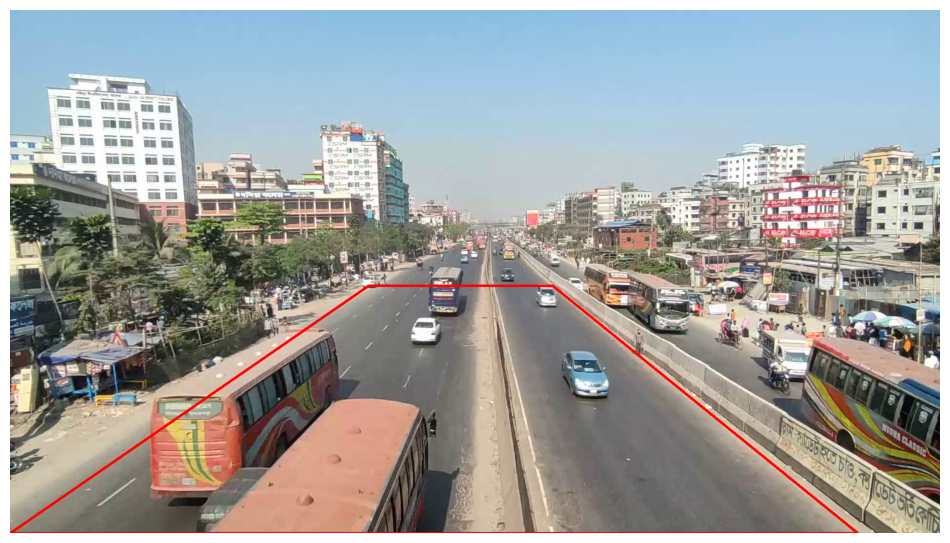

In [10]:
annotated_frame = frame.copy()
annotated_frame = sv.draw_polygon(scene=annotated_frame, polygon=SOURCE, color=sv.Color.RED, thickness=4)
sv.plot_image(annotated_frame)

## Transform Perspective

In [11]:
class ViewTransformer:

    def __init__(self, source: np.ndarray, target: np.ndarray) -> None:
        source = source.astype(np.float32)
        target = target.astype(np.float32)
        self.m = cv2.getPerspectiveTransform(source, target)

    def transform_points(self, points: np.ndarray) -> np.ndarray:
        if points.size == 0:
            return points

        reshaped_points = points.reshape(-1, 1, 2).astype(np.float32)
        transformed_points = cv2.perspectiveTransform(reshaped_points, self.m)
        return transformed_points.reshape(-1, 2)

In [12]:
view_transformer = ViewTransformer(source=SOURCE, target=TARGET)

## Process Video

In [13]:
#import supervision
#l = [dir(supervision)]
#l

In [14]:
import supervision
help(supervision)


Help on package supervision:

NAME
    supervision

PACKAGE CONTENTS
    annotators (package)
    assets (package)
    classification (package)
    config
    dataset (package)
    detection (package)
    draw (package)
    geometry (package)
    keypoint (package)
    metrics (package)
    tracker (package)
    utils (package)
    validators (package)

VERSION
    0.25.1

FILE
    /usr/local/lib/python3.11/dist-packages/supervision/__init__.py




#Use of Supervision Annotators.

In [17]:
model = YOLO(MODEL_NAME)

video_info = sv.VideoInfo.from_video_path(video_path=SOURCE_VIDEO_PATH)
frame_generator = sv.get_video_frames_generator(source_path=SOURCE_VIDEO_PATH)

byte_track = sv.ByteTrack(frame_rate=video_info.fps)

thickness = sv.calculate_optimal_line_thickness(resolution_wh=video_info.resolution_wh)
text_scale = sv.calculate_optimal_text_scale(resolution_wh=video_info.resolution_wh)
bounding_box_annotator = sv.BoxAnnotator(thickness=thickness)
label_annotator = sv.LabelAnnotator(
    text_scale=text_scale,
    text_thickness=thickness,
    text_position=sv.Position.BOTTOM_CENTER
)
trace_annotator = sv.TraceAnnotator(
    thickness=thickness,
    trace_length=video_info.fps * 2,
    position=sv.Position.BOTTOM_CENTER
)

polygon_zone = sv.PolygonZone(polygon=SOURCE)

coordinates = defaultdict(lambda: deque(maxlen=video_info.fps))

with sv.VideoSink(TARGET_VIDEO_PATH, video_info) as sink:
    for frame in tqdm(frame_generator, total=video_info.total_frames):
        result = model(frame, imgsz=MODEL_RESOLUTION, verbose=False)[0]
        detections = sv.Detections.from_ultralytics(result)

        detections = detections[detections.confidence > CONFIDENCE_THRESHOLD]
        detections = detections[detections.class_id != 0]

        detections = detections[polygon_zone.trigger(detections)]

        detections = detections.with_nms(IOU_THRESHOLD)

        detections = byte_track.update_with_detections(detections=detections)

        points = detections.get_anchors_coordinates(anchor=sv.Position.BOTTOM_CENTER)

        points = view_transformer.transform_points(points=points).astype(int)

        for tracker_id, [_, y] in zip(detections.tracker_id, points):
            coordinates[tracker_id].append(y)

        labels = []
        for tracker_id in detections.tracker_id:
            if len(coordinates[tracker_id]) < video_info.fps / 2:
                labels.append(f"#{tracker_id}")
            else:
                coordinate_start = coordinates[tracker_id][-1]
                coordinate_end = coordinates[tracker_id][0]
                distance = abs(coordinate_start - coordinate_end)
                time = len(coordinates[tracker_id]) / video_info.fps
                speed = distance / time * 3.6
                labels.append(f"#{tracker_id} {int(speed)} km/h")

        annotated_frame = frame.copy()
        annotated_frame = trace_annotator.annotate(scene=annotated_frame, detections=detections)
        annotated_frame = bounding_box_annotator.annotate(scene=annotated_frame, detections=detections)
        annotated_frame = label_annotator.annotate(scene=annotated_frame, detections=detections, labels=labels)

        sink.write_frame(annotated_frame)

100%|██████████| 2223/2223 [06:17<00:00,  5.88it/s]
